In [1]:
import os

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pycbc.coordinates

In [5]:
def draw_inc_coa_phase_samples(npts, mass_ratio=1, spin1_mag=0, spin1_phi=0, spin1_theta=0, spin2_mag=0, spin2_phi=0, spin2_theta=0):
    """
    draw npts samples from the inc-coa_phase with other parameters fixed
    """
    
    mass_ratio = np.array([mass_ratio]*npts)
    
    spin1_mag = np.array([spin1_mag]*npts)
    spin1_phi = np.array([spin1_phi]*npts)
    spin1_theta = np.array([spin1_theta]*npts)
    
    spin2_mag = np.array([spin2_mag]*npts)
    spin2_phi = np.array([spin2_phi]*npts)
    spin2_theta = np.array([spin2_theta]*npts)
    
    
    spin1x, spin1y, spin1z = pycbc.coordinates.spherical_to_cartesian(spin1_mag, spin1_phi, spin1_theta)
    
    spin2x, spin2y, spin2z = pycbc.coordinates.spherical_to_cartesian(spin2_mag, spin2_phi, spin2_theta)
    
    # coa_phase and inclination
    _, coa_phase, inclination = sample_3d_sphere_uniform(npts)
    
    return mass_ratio, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, coa_phase, inclination

In [6]:

def sample_3d_sphere_uniform(npts):
    """
    generates random x,y,z 3d vector components
    distributed uniformly (isotropic?) in a 3-sphere.
    """
    
    spin_mag = np.random.uniform(0, 1, npts)
    
    # correction to the magnitude of the vector so that
    # there isn't an over density near the centre.
    # Don't really understand though.
    R = 0.99 # this is the maximum magnitude
    spin_mag = R * np.cbrt( spin_mag )
    
    spin_phi = np.random.uniform(0, 2*np.pi, npts)
    spin_theta = np.arccos(np.random.uniform(-1, 1, npts))
    
    
    return spin_mag, spin_phi, spin_theta

# generate waveform

In [7]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

import numpy as np

import sklearn.preprocessing
import sklearn.model_selection

import pycbc.types
import pycbc.waveform
import pycbc.pnutils
import pycbc.conversions

import lal
import lalsimulation as lalsim
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [8]:
import tensorflow as tf
import wispy.callbacks
import tensorflow_addons as tfa

In [9]:
from tf_fourier_features import FourierFeatureProjection

In [10]:
import pycbc.coordinates

In [11]:
def StoM(S, Mtot):
    """StoM(S, Mtot)
    """
    return S / (lal.MTSUN_SI*Mtot)

def MtoS(M, Mtot):
    """MtoS(Hz, Mtot)
    """
    return M * (lal.MTSUN_SI*Mtot)

def td_amp_scale(mtot, distance):
    """
    mtot in solar masses
    distance in m
    M*G/c^2 * M_sun / dist
    """
    return mtot * lal.MRSUN_SI / distance



def MftoHz(Mf, M):
    """MftoHz(Mf, M)
    """
    return Mf / (lal.MTSUN_SI*M)

def HztoMf(Hz, M):
    """HztoMf(Hz, M)
    """
    return Hz * (lal.MTSUN_SI*M)

In [12]:
def generate_waveform(
    new_times_M,
    time_idxs=None, # indicies at which to return the data on
    mass_ratio=1,
    total_mass=100,
    spin1x=0,
    spin1y=0,
    spin1z=0,
    spin2x=0,
    spin2y=0,
    spin2z=0,
    inclination=0,
    coa_phase=0,
    approximant="SEOBNRv4_opt",
    distance_mpc=1):
    
    mass1=pycbc.conversions.mass1_from_mtotal_q(total_mass, mass_ratio)
    mass2=pycbc.conversions.mass2_from_mtotal_q(total_mass, mass_ratio)
    
    # https://github.com/gwastro/pycbc/blob/master/pycbc/coordinates.py#L117
    # spin1x, spin1y, spin1z = pycbc.coordinates.spherical_to_cartesian(r_1, phi_1, theta_1)

    # mass1=pycbc.conversions.mass1_from_mtotal_q(100, 4)
    # mass2=pycbc.conversions.mass2_from_mtotal_q(100, 4)

    # can scale amp by eta
    # eta = pycbc.conversions.eta_from_mass1_mass2(mass1, mass2)

    params = dict(
        # spin1x=mass_ratio,
        mass1=mass1,
        mass2=mass2,
        spin1x=spin1x,
        spin1y=spin1y,
        spin1z=spin1z,
        spin2x=spin2x,
        spin2y=spin2y,
        spin2z=spin2z,
        approximant=approximant,
        f_lower=10,
        delta_t=1/4096,
        distance=distance_mpc,
        inclination=inclination,
        coa_phase=coa_phase,
        )
    hp, hc = pycbc.waveform.get_td_waveform(**params)
    delta_t = hp.delta_t

    amp = pycbc.waveform.utils.amplitude_from_polarizations(hp, hc).numpy()
    phase = pycbc.waveform.utils.phase_from_polarizations(hp, hc, remove_start_phase=True).numpy()

    times_M = StoM(hp.sample_times.numpy(), total_mass)

    new_amp = IUS(times_M, amp)(new_times_M)

    distance_m = 1e6*distance_mpc*lal.PC_SI
    new_amp /= td_amp_scale(total_mass, distance_m)

    new_phase = IUS(times_M, phase)(new_times_M)
    new_phase += -new_phase[0]

    h = new_amp * np.exp(-1.j * new_phase)
    hp = np.real(h)
    # hc = np.imag(h)
    
    if time_idxs is not None:
        hp = hp[time_idxs]
        
    return hp
    # return hc
    # return new_amp
    # return new_phase

In [13]:
# uniform spacing throughout
t1 = -2000
t2 = 70
dt = 0.5
new_times_M = np.arange(t1, t2, dt)

In [14]:
new_times_M.shape

(4140,)

In [15]:
t_idxs = np.arange(len(new_times_M))
t_training_idxs = t_idxs[::2]
t_validation_idxs = t_idxs[1::2]

In [16]:
t_training_idxs.shape

(2070,)

In [17]:
t_validation_idxs.shape

(2070,)

(-10.0, 10.0)

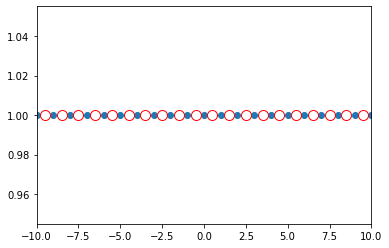

In [18]:
plt.plot(new_times_M[t_training_idxs], np.ones_like(new_times_M[t_training_idxs]), 'o')
plt.plot(new_times_M[t_validation_idxs], np.ones_like(new_times_M[t_validation_idxs]), 'o', mfc='none', c='r', markersize=10)
plt.xlim(-10, 10)

In [19]:
def generate_dataset(n_samples, new_times_M, time_idxs):
    # mass_ratio, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, coa_phase, inclination = draw_9d_samples(n_samples)
    mass_ratio, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, coa_phase, inclination = draw_inc_coa_phase_samples(n_samples, mass_ratio=4, spin1_mag=0.5, spin1_phi=0, spin1_theta=0., spin2_mag=0, spin2_phi=0, spin2_theta=0)
    # mass_ratio, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, coa_phase, inclination = draw_spin1_mag_spin1_theta_samples(n_samples, mass_ratio=3, spin1_phi=0, spin2_mag=0, spin2_phi=0, spin2_theta=0, inclination=0, coa_phase=0)
    # mass_ratio, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, coa_phase, inclination = draw_mass_ratio_spin1_mag_spin1_theta_samples(n_samples, spin1_phi=0, spin2_mag=0, spin2_phi=0, spin2_theta=0, inclination=0, coa_phase=0)
    # mass_ratio, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, coa_phase, inclination = draw_mass_ratio_samples(n_samples, spin1_mag=0.99, spin1_theta=np.pi/2)
    
    
    # mass_ratio, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, coa_phase, inclination = draw_spin1_mag_samples(n_samples, mass_ratio=3, spin1_phi=0, spin1_theta=np.pi/2, spin2_mag=0, spin2_phi=0, spin2_theta=0, inclination=0, coa_phase=0)

    params = dict(
        new_times_M=new_times_M,
        time_idxs=time_idxs,
        total_mass=100,
        approximant="IMRPhenomXP",
        distance_mpc=1
    )

    hps=[]
    for i in range(n_samples):
        
        params.update(
            dict(
                mass_ratio=mass_ratio[i],
                spin1x=spin1x[i],
                spin1y=spin1y[i],
                spin1z=spin1z[i],
                spin2x=spin2x[i],
                spin2y=spin2y[i],
                spin2z=spin2z[i],
                inclination=inclination[i],
                coa_phase=coa_phase[i]
            )
        )

        hp = generate_waveform(**params)
        hps.append(hp)
        
    # X = np.column_stack((mass_ratio, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, coa_phase, inclination))
    # X = np.column_stack((mass_ratio, spin1x, spin1y, spin1z))
    X = np.column_stack((mass_ratio, coa_phase, inclination, spin1z))
    return np.row_stack(hps), X, new_times_M[time_idxs][:,np.newaxis]

In [25]:
# uniform spacing throughout
t1 = -2000
# t1 = -500
# t1 = -200
# t1 = -50
t2 = 70
dt = 0.25
new_times_M = np.arange(t1, t2, dt)

In [26]:
new_times_M.shape

(8280,)

In [27]:
n_samples_train=10000
n_samples_val=100

# n_samples_train=3
# n_samples_val=3

In [28]:
t_idxs = np.arange(len(new_times_M))
t_training_idxs = t_idxs[::2]
t_validation_idxs = t_idxs[1::2]

In [29]:
%%time
y_train, theta_train, times_train = generate_dataset(n_samples_train, new_times_M, t_training_idxs)

CPU times: user 10min 1s, sys: 5min 29s, total: 15min 30s
Wall time: 3min 20s


In [30]:
t_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))
theta_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))

times_train_scaled = t_scaler.fit_transform(times_train)
theta_train_scaled = theta_scaler.fit_transform(theta_train)

In [31]:
y_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))

y_train_shape = y_train.shape
y_train_scaled_flat = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_train_scaled = y_train_scaled_flat.reshape(y_train_shape)

In [32]:
%%time
y_val, theta_val, times_val = generate_dataset(n_samples_val, new_times_M, t_validation_idxs)

CPU times: user 6.62 s, sys: 4.06 s, total: 10.7 s
Wall time: 2.23 s


In [33]:
times_val_scaled = t_scaler.transform(times_val)
theta_val_scaled = theta_scaler.transform(theta_val)

y_val_shape = y_val.shape
y_val_scaled_flat = y_scaler.transform(y_val.reshape(-1, 1))
y_val_scaled = y_val_scaled_flat.reshape(y_val_shape)

In [34]:
y_train_scaled_flat.shape

(41400000, 1)

In [35]:
y_val_scaled_flat.shape

(414000, 1)

In [36]:
theta_train.shape

(10000, 4)

In [37]:
y_train.shape

(10000, 4140)

In [38]:
times_train.shape

(4140, 1)

In [39]:
y_train_scaled.shape

(10000, 4140)

In [40]:
y_val_scaled.shape

(100, 4140)

In [41]:
theta_train_scaled.shape

(10000, 4)

In [42]:
times_train_scaled.shape

(4140, 1)

In [43]:
theta_train[:,1].argmax()

8151

In [44]:
theta_train[:,1].max()

6.282822445973874

In [45]:
theta_train[theta_train[:,1].argmax()]

array([4.        , 6.28282245, 0.51188153, 0.5       ])

In [46]:
np.linalg.norm(theta_train[theta_train[:,1].argmax(),1:4])

6.323438984405191

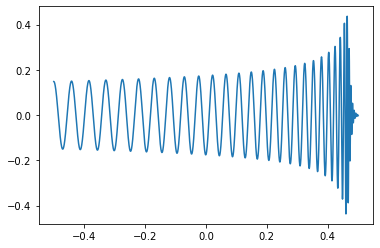

In [47]:
plt.plot(times_train_scaled, y_train_scaled[theta_train[:,1].argmax()])

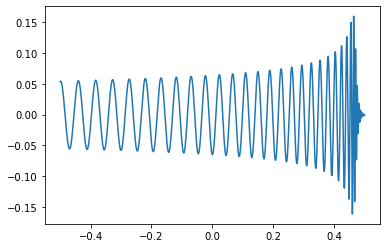

In [48]:
plt.plot(times_train_scaled, y_train_scaled[0])

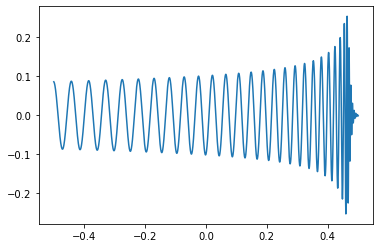

In [49]:
plt.plot(times_val_scaled, y_val_scaled[0])

In [50]:
def build_input_single_q(t, *args):
    """
    t is a matrix i.e. shape = (-1, 1)
    list of parameters
    """
    theta = np.array([*args])
    theta = np.ones_like(t) * theta

    return np.column_stack((t, theta))

In [51]:
build_input_single_q(np.arange(0, 1, 0.1)[:,np.newaxis], [1,2,3])

array([[0. , 1. , 2. , 3. ],
       [0.1, 1. , 2. , 3. ],
       [0.2, 1. , 2. , 3. ],
       [0.3, 1. , 2. , 3. ],
       [0.4, 1. , 2. , 3. ],
       [0.5, 1. , 2. , 3. ],
       [0.6, 1. , 2. , 3. ],
       [0.7, 1. , 2. , 3. ],
       [0.8, 1. , 2. , 3. ],
       [0.9, 1. , 2. , 3. ]])

In [52]:
def build_input_multiple_q(t, thetas):
    """
    t is a vector
    thetas is a vector
    """
    return np.row_stack([build_input_single_q(t, *theta) for theta in thetas])

In [53]:
theta_train_scaled.shape

(10000, 4)

In [54]:
# X_train = build_input_multiple_q(times_train_scaled, theta_train_scaled)
X_train = build_input_multiple_q(times_train, theta_train)

In [55]:
X_train.shape

(41400000, 5)

In [56]:
X_train[0]

array([-2.00000000e+03,  4.00000000e+00,  5.01858935e+00,  1.89322881e+00,
        5.00000000e-01])

In [57]:
# X_val = build_input_multiple_q(times_val_scaled, theta_val_scaled)
X_val = build_input_multiple_q(times_val, theta_val)

In [58]:
X_val.shape

(414000, 5)

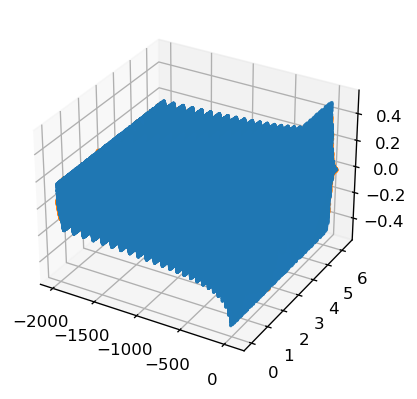

In [59]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:,0], X_train[:,2], y_train_scaled, s=1)
ax.scatter(X_val[:,0], X_val[:,2], y_val_scaled, s=6)

In [60]:
# https://stackoverflow.com/a/71990796

TRAINING_POISON_PILL_FILE_NAME = 'stop-training'

class PoisonPillCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if os.path.exists(TRAINING_POISON_PILL_FILE_NAME):
            self.model.stop_training = True
            os.remove(TRAINING_POISON_PILL_FILE_NAME)
            print(f'poison pill file "{TRAINING_POISON_PILL_FILE_NAME}" detected, stopping training')

In [138]:
def run_model(X_train, y_train, time_b_scale, theta_b_scale, epochs=1001, threshold=1e-7, batch_size=32, validation_data=None, verbose=0):
    activation = 'relu'
    fan_in=128
    units = 256
    n_layers = 3
    
    
    # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecayRestarts1
    lrs = tf.keras.optimizers.schedules.CosineDecayRestarts(
        1e-3,
        # 1000,
        5,
        t_mul=2.0,
        m_mul=1.0,
        alpha=0.0,
        name=None
    )
    
    # https://www.tensorflow.org/addons/tutorials/optimizers_cyclicallearningrate
    # epochs=104
    # batch_size=32
    steps_per_epoch = len(X_train) // batch_size
    print(steps_per_epoch)
    step = np.arange(0, epochs * steps_per_epoch)
    lr_ = lrs(step)
    
    plt.figure()
    plt.plot(step/steps_per_epoch, lr_)
    plt.xlabel("epoch")
    plt.title("learning rate schedule")
    plt.yscale('log')
    plt.xscale('log')
    plt.show()
    plt.close()
    
    time_kernel_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=time_b_scale)
    time_bias_initializer = tf.keras.initializers.RandomUniform(minval=-1., maxval=1.)
    
    theta_kernel_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=theta_b_scale)
    theta_bias_initializer = tf.keras.initializers.RandomUniform(minval=-1., maxval=1.)
    
    time_input = tf.keras.Input(shape=(1,), name='time_input')
    theta_input = tf.keras.Input(shape=(4,), name='theta_input')
    
    x_time = tf.keras.layers.Dense(fan_in, kernel_initializer=time_kernel_initializer, bias_initializer=time_bias_initializer, trainable=False)(time_input)
    x_time = tf.keras.layers.Lambda(lambda x: tf.math.sin(np.pi*x))(x_time)
    
    x_theta = tf.keras.layers.Dense(fan_in, kernel_initializer=theta_kernel_initializer, bias_initializer=theta_bias_initializer, trainable=False)(theta_input)
    x_theta = tf.keras.layers.Lambda(lambda x: tf.math.sin(np.pi*x))(x_theta)
    # x_theta = tf.keras.layers.Dense(fan_in, activation='relu')(theta_input)
    
    x = tf.keras.layers.Concatenate()([x_time, x_theta])
    
    for i in range(n_layers):
        x = tf.keras.layers.Dense(units, activation)(x)
    x = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=[time_input, theta_input], outputs=x)
    
    print(model.summary())
    
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
    checkpoint_filepath = './checkpoint_dir/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        save_best_only=True)

    
    
    
    
    
    callbacks = [
        # tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(threshold),
        model_checkpoint_callback,
        PoisonPillCallback(),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.9, monitor='val_loss'),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.6, monitor='val_loss'),
        
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=80, factor=0.2, monitor='val_loss'),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=10, factor=0.2, monitor='val_loss'),
        
        
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.1, monitor='val_loss'),
        # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300),
        # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
    ]
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lrs))

    history = model.fit(x=[X_train[:,0], X_train[:,1:]], y=y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data)
    
    # The model weights (that are considered the best) are loaded into the model.
    print("loading best weights from checkpoint")
    model.load_weights(checkpoint_filepath)

    return history, model


In [139]:
# epochs=2000
# epochs=200
# epochs=300
# epochs=100
epochs=65
# batch_size = 8
# batch_size = 32
# batch_size = 128
# batch_size = 512
batch_size = 1024
# batch_size = 2048
print(batch_size)

# learning_rate = 1e-3
# learning_rate = 1e-4
# print(learning_rate)

1024


In [140]:
X_train.shape

(41400000, 5)

In [141]:
X_val.shape

(414000, 5)

In [142]:
pycbc.conversions.mass1_from_mtotal_q(100, 3)

75.0

In [143]:
pycbc.conversions.mass2_from_mtotal_q(100, 3)

25.0

In [144]:
f_rd_mf = HztoMf(pycbc.pnutils._get_final_freq(approx=lalsim.SEOBNRv4, m1=75, m2=25, s1z=0.99, s2z=0.99), 100)
f_rd_mf

0.1367675815410475

40429


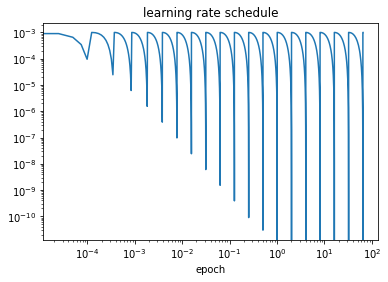

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 theta_input (InputLayer)       [(None, 4)]          0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 128)          256         ['time_input[0][0]']             
                                                                                                  
 dense_7 (Dense)                (None, 128)          640         ['theta_input[0][0]']            
                                                                                            

2022-07-02 23:44:54.826799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40430/40430 [==============================] - ETA: 0s - loss: 1.5358e-04

2022-07-02 23:50:54.333616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40430/40430 [==============================] - 362s 9ms/step - loss: 1.5358e-04 - val_loss: 7.6879e-07
Epoch 2/65
40430/40430 [==============================] - 349s 9ms/step - loss: 2.4853e-06 - val_loss: 4.5142e-07
Epoch 3/65
40430/40430 [==============================] - 351s 9ms/step - loss: 2.3562e-06 - val_loss: 7.8035e-07
loading best weights from checkpoint
CPU times: user 12min 29s, sys: 9min 27s, total: 21min 57s
Wall time: 17min 44s


In [145]:
%%time
history, model = run_model(
    X_train,
    y_train_scaled_flat,
    time_b_scale=f_rd_mf,
    # theta_b_scale=2,
    theta_b_scale=1,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([X_val[:,0], X_val[:,1:]], y_val_scaled_flat),
    threshold=1e-7,
    verbose=1,
    )

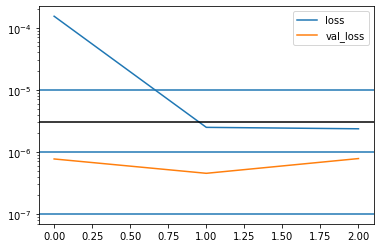

In [146]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.axhline(1e-5)
plt.axhline(1e-6)
plt.axhline(3e-6, c='k')
plt.axhline(1e-7)
plt.yscale("log")


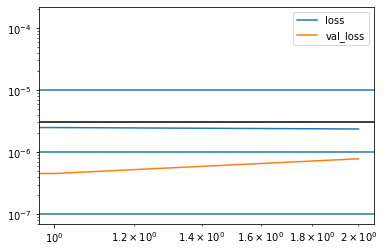

In [147]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.axhline(1e-5)
plt.axhline(1e-6)
plt.axhline(3e-6, c='k')
plt.axhline(1e-7)

In [148]:
try:
    plt.figure()
    plt.plot(history.history["lr"], label='lr')
    plt.legend()
    plt.yscale("log")
    # plt.xscale("log")
except:
    pass

<Figure size 432x288 with 0 Axes>

In [149]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 theta_input (InputLayer)       [(None, 4)]          0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 128)          256         ['time_input[0][0]']             
                                                                                                  
 dense_7 (Dense)                (None, 128)          640         ['theta_input[0][0]']            
                                                                                            

In [150]:
# test_input = build_input_single_q(times_train_scaled, *theta_val_scaled[-1])
test_input = build_input_single_q(times_train, *theta_val[-1])
# test_yhat = model.predict([test_input[:,0], test_input[:,1:]], verbose=0)
test_yhat = model([test_input[:,0], test_input[:,1:]])

In [151]:
test_input.shape

(4140, 5)

In [152]:
# %%timeit
# # model.predict([test_input[:,0], test_input[:,1:]], verbose=0)
# model([test_input[:,0], test_input[:,1:]])

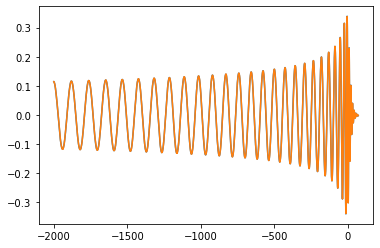

In [153]:
plt.plot(test_input[:,0], y_val_scaled[-1])
plt.plot(test_input[:,0], test_yhat[:,0], ls='-')
# plt.xlim(0.3, 0.5)
# plt.yscale('log')

(-500.0, 100.0)

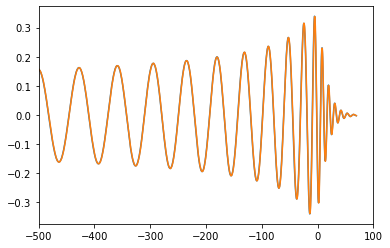

In [154]:
plt.plot(test_input[:,0], y_val_scaled[-1])
plt.plot(test_input[:,0], test_yhat[:,0], ls='-')
plt.xlim(-500, 100)
# plt.yscale('log')

In [155]:
X_val.shape

(414000, 5)

In [156]:
theta_val.shape

(100, 4)

In [157]:
times_val_scaled.shape

(4140, 1)

In [158]:
# yhat_val = model.predict([X_validation[:,0], X_validation[:,1:]], verbose=0)
yhat_val = model([X_val[:,0], X_val[:,1:]])

# this is: (num waveforms, num time samples)
shape_ = (theta_val.shape[0], times_val_scaled.shape[0])
print(shape_)

# yhat_val = yhat_val.reshape(shape_)
yhat_val = yhat_val.numpy().reshape(shape_)

(100, 4140)


In [159]:
mse_val = tf.keras.losses.mean_squared_error(y_val_scaled, yhat_val)

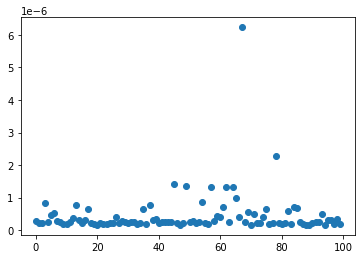

In [160]:
plt.plot(mse_val, 'o')

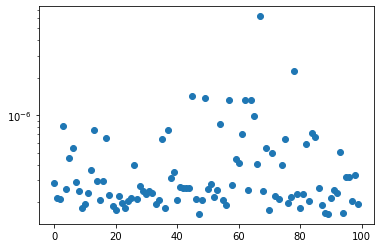

In [161]:
plt.plot(mse_val, 'o')
plt.yscale('log')

In [162]:
mse_val.shape

TensorShape([100])

In [163]:
print(mse_val.numpy().min())
print(mse_val.numpy().max())
print(mse_val.numpy().mean())
print(np.median(mse_val.numpy()))

1.6103877e-07
6.236123e-06
4.514229e-07
2.4994068e-07


Text(0, 0.5, 'spin1x')

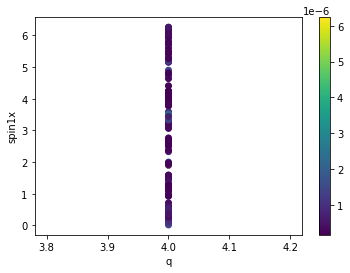

In [164]:
plt.scatter(theta_val[:,0], theta_val[:,1], c=mse_val)
plt.colorbar()
plt.xlabel('q')
plt.ylabel('spin1x')

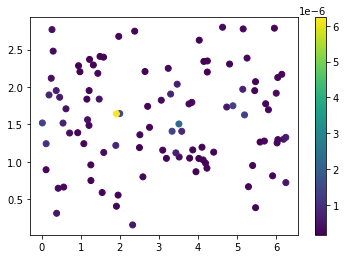

In [165]:
plt.scatter(theta_val[:,1], theta_val[:,2], c=mse_val)
plt.colorbar()
# plt.xlabel('q')
# plt.ylabel('spin1x')

Text(0, 0.5, 'spin1z')

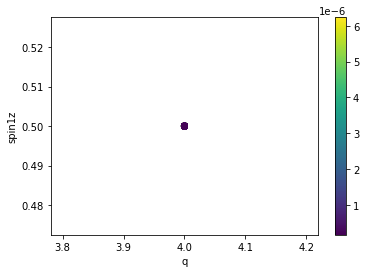

In [166]:
plt.scatter(theta_val[:,0], theta_val[:,3], c=mse_val)
plt.colorbar()
plt.xlabel('q')
plt.ylabel('spin1z')

Text(0, 0.5, 'spin1z')

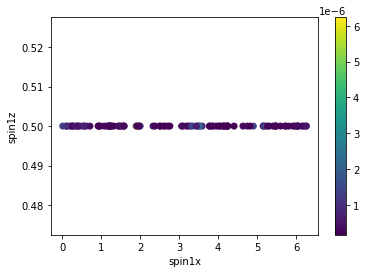

In [167]:
plt.scatter(theta_val[:,1], theta_val[:,3], c=mse_val)
plt.colorbar()
plt.xlabel('spin1x')
plt.ylabel('spin1z')

In [168]:
worst_idx = np.argmax(mse_val)
worst_idx


67

In [169]:
theta_val[worst_idx]

array([4.        , 1.91362055, 1.64163878, 0.5       ])

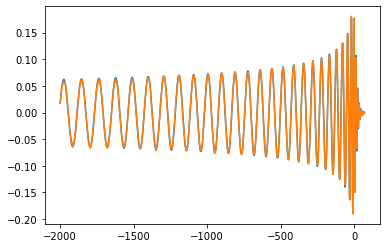

In [170]:
plt.figure()
plt.plot(times_val, y_val_scaled[worst_idx])
plt.plot(times_val, yhat_val[worst_idx])
# plt.xlim(-100, 120)

(-500.0, 120.0)

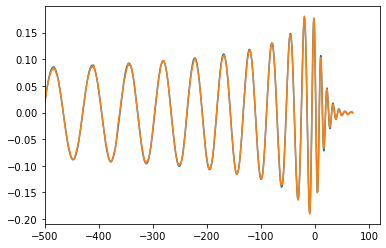

In [171]:
plt.figure()
plt.plot(times_val, y_val_scaled[worst_idx])
plt.plot(times_val, yhat_val[worst_idx])
plt.xlim(-500, 120)

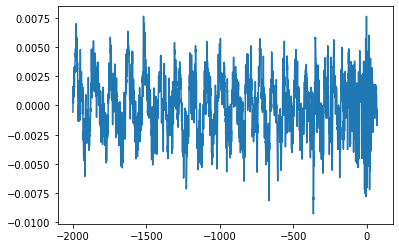

In [172]:
plt.figure()
plt.plot(times_val, y_val_scaled[worst_idx]-yhat_val[worst_idx])
# plt.xlim(-100, 120)

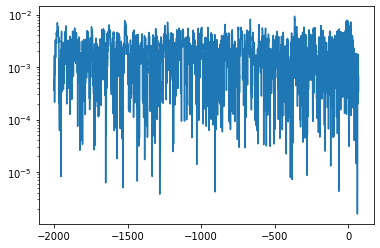

In [173]:
plt.figure()
plt.plot(times_val, np.abs(y_val_scaled[worst_idx]-yhat_val[worst_idx]))
# plt.xlim(-100, 120)
plt.yscale('log')

# now try with generator

In [61]:
import dataset

In [63]:
import importlib
importlib.reload(dataset)

<module 'dataset' from '/Users/sebastian.khan/personal/git/stk/ml/waveforms/jun2022/m1/dataset.py'>

In [64]:
times_train.shape

(4140, 1)

In [65]:
theta_train.shape

(10000, 4)

In [66]:
y_train_scaled.shape

(10000, 4140)

In [67]:
theta_train

array([[4.        , 5.01858935, 1.89322881, 0.5       ],
       [4.        , 2.31402939, 1.53591021, 0.5       ],
       [4.        , 0.77322579, 2.77135801, 0.5       ],
       ...,
       [4.        , 4.1075361 , 0.7658154 , 0.5       ],
       [4.        , 0.77592915, 2.55225236, 0.5       ],
       [4.        , 3.4159624 , 1.25971737, 0.5       ]])

In [68]:
# importlib.reload(dataset)

In [69]:
train_ds = dataset.DataGen(thetas=theta_train, times=times_train, ys=y_train_scaled, batch_size=512, shuffle=True)

In [70]:
val_ds = dataset.DataGen(thetas=theta_val, times=times_val, ys=y_val_scaled, batch_size=512, shuffle=True)

In [71]:
train_ds.__len__()

80860

In [72]:
val_ds.__len__()

809

In [73]:
train_ds.total_number_of_points

41400000

In [74]:
train_ds.total_number_of_features

5

In [75]:
X_train.shape

(41400000, 5)

In [76]:
theta_train

array([[4.        , 5.01858935, 1.89322881, 0.5       ],
       [4.        , 2.31402939, 1.53591021, 0.5       ],
       [4.        , 0.77322579, 2.77135801, 0.5       ],
       ...,
       [4.        , 4.1075361 , 0.7658154 , 0.5       ],
       [4.        , 0.77592915, 2.55225236, 0.5       ],
       [4.        , 3.4159624 , 1.25971737, 0.5       ]])

In [77]:
times_train[1]

array([-1999.5])

In [78]:
X_train[1]

array([-1.99950000e+03,  4.00000000e+00,  5.01858935e+00,  1.89322881e+00,
        5.00000000e-01])

In [79]:
for num, (data, labels) in enumerate(train_ds):
    # print(f"num: {num}")
    print(data[0].shape, data[1].shape)
    print(data.shape, labels.shape)
    print(data, labels)
    if num > 1:
        break

(512,) (512, 4)


AttributeError: 'tuple' object has no attribute 'shape'

In [80]:
import numpy as np
import dataset

In [81]:
import importlib
importlib.reload(dataset)

<module 'dataset' from '/Users/sebastian.khan/personal/git/stk/ml/waveforms/jun2022/m1/dataset.py'>

In [82]:
# num_time_samples > num_waveforms ???
# other wise place switch in the code?

In [83]:
####
np.random.seed(1)
num_waveforms = 5
num_time_samples = 3
num_phys_feats = 4
theta = np.random.random(size=(num_waveforms, num_phys_feats))
times = np.random.random(size=(num_time_samples, 1))
ys = np.arange(num_waveforms*num_time_samples).reshape(num_waveforms, num_time_samples)
ds = dataset.DataGen(thetas=theta, times=times, ys=ys, batch_size=num_waveforms*num_time_samples, shuffle=False)
####

In [84]:
ds.indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [85]:
theta_indices, time_indices = dataset.inv_super_index(I=ds.indices, width=num_time_samples)
print(theta_indices)
print(time_indices)

[0 0 0 1 1 1 2 2 2 3 3 3 4 4 4]
[0 1 2 0 1 2 0 1 2 0 1 2 0 1 2]


In [86]:
ds.total_number_of_points

15

In [87]:
ds.total_number_of_features

5

In [88]:
ds.__len__()

1

In [89]:
for num, (data, labels) in enumerate(ds):
    # print(f"num: {num}")
    print(data.shape, labels.shape)
    print(data, labels)
    if num > 1:
        break

AttributeError: 'tuple' object has no attribute 'shape'

In [96]:
def run_model_ds(train_ds, time_b_scale, theta_b_scale, epochs=1001, threshold=1e-7, batch_size=32, validation_data=None, verbose=0):
    activation = 'relu'
    fan_in=128
    units = 256
    n_layers = 3
    
    
    # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecayRestarts1
    lrs = tf.keras.optimizers.schedules.CosineDecayRestarts(
        1e-3,
        # 1000,
        5,
        t_mul=2.0,
        m_mul=1.0,
        alpha=0.0,
        name=None
    )
    
    # https://www.tensorflow.org/addons/tutorials/optimizers_cyclicallearningrate
    # epochs=104
    # batch_size=32
    steps_per_epoch = len(X_train) // batch_size
    print(steps_per_epoch)
    step = np.arange(0, epochs * steps_per_epoch)
    lr_ = lrs(step)
    
    plt.figure()
    plt.plot(step/steps_per_epoch, lr_)
    plt.xlabel("epoch")
    plt.title("learning rate schedule")
    plt.yscale('log')
    plt.xscale('log')
    plt.show()
    plt.close()
    
    time_kernel_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=time_b_scale)
    time_bias_initializer = tf.keras.initializers.RandomUniform(minval=-1., maxval=1.)
    
    theta_kernel_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=theta_b_scale)
    theta_bias_initializer = tf.keras.initializers.RandomUniform(minval=-1., maxval=1.)
    
    time_input = tf.keras.Input(shape=(1,), name='time_input')
    theta_input = tf.keras.Input(shape=(4,), name='theta_input')
    
    x_time = tf.keras.layers.Dense(fan_in, kernel_initializer=time_kernel_initializer, bias_initializer=time_bias_initializer, trainable=False)(time_input)
    x_time = tf.keras.layers.Lambda(lambda x: tf.math.sin(np.pi*x))(x_time)
    
    x_theta = tf.keras.layers.Dense(fan_in, kernel_initializer=theta_kernel_initializer, bias_initializer=theta_bias_initializer, trainable=False)(theta_input)
    x_theta = tf.keras.layers.Lambda(lambda x: tf.math.sin(np.pi*x))(x_theta)
    # x_theta = tf.keras.layers.Dense(fan_in, activation='relu')(theta_input)
    
    x = tf.keras.layers.Concatenate()([x_time, x_theta])
    
    for i in range(n_layers):
        x = tf.keras.layers.Dense(units, activation)(x)
    x = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=[time_input, theta_input], outputs=x)
    
    print(model.summary())
    
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
    checkpoint_filepath = './checkpoint_dir/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        save_best_only=True)

    
    
    
    
    
    callbacks = [
        # tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(threshold),
        model_checkpoint_callback,
        PoisonPillCallback(),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.9, monitor='val_loss'),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.6, monitor='val_loss'),
        
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=80, factor=0.2, monitor='val_loss'),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=10, factor=0.2, monitor='val_loss'),
        
        
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.1, monitor='val_loss'),
        # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300),
        # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
    ]
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lrs))

    # history = model.fit(train_ds, epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data)
    history = model.fit(train_ds, epochs=epochs, verbose=verbose, callbacks=callbacks, validation_data=validation_data)
    
    # The model weights (that are considered the best) are loaded into the model.
    print("loading best weights from checkpoint")
    model.load_weights(checkpoint_filepath)

    return history, model


In [97]:
epochs=65
batch_size = 1024
# batch_size = 2048

In [98]:
train_ds = dataset.DataGen(thetas=theta_train, times=times_train, ys=y_train_scaled, batch_size=batch_size, shuffle=True)

In [99]:
val_ds = dataset.DataGen(thetas=theta_val, times=times_val, ys=y_val_scaled, batch_size=batch_size, shuffle=False)

In [100]:
f_rd_mf = HztoMf(pycbc.pnutils._get_final_freq(approx=lalsim.SEOBNRv4, m1=75, m2=25, s1z=0.99, s2z=0.99), 100)
f_rd_mf

0.1367675815410475

In [101]:
%%time
history, model = run_model_ds(
    train_ds,
    time_b_scale=f_rd_mf,
    # theta_b_scale=2,
    theta_b_scale=1,
    epochs=epochs,
    validation_data=val_ds,
    threshold=1e-7,
    verbose=1,
    )

1293750
Metal device set to: Apple M1 Pro


2022-07-02 23:23:03.442287: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-02 23:23:03.442532: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 theta_input (InputLayer)       [(None, 4)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          256         ['time_input[0][0]']             
                                                                                                  
 dense_1 (Dense)                (None, 128)          640         ['theta_input[0][0]']            
                                                                                              

2022-07-02 23:23:19.585213: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-02 23:23:19.841815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40427/40430 [============================>.] - ETA: 0s - loss: 1.5846e-04

2022-07-02 23:29:26.197687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40430/40430 [==============================] - 368s 9ms/step - loss: 1.5845e-04 - val_loss: 6.4983e-07
Epoch 2/65
40430/40430 [==============================] - 390s 10ms/step - loss: 1.9111e-06 - val_loss: 3.4133e-07
Epoch 3/65
40430/40430 [==============================] - 380s 9ms/step - loss: 1.7550e-06 - val_loss: 6.3417e-07
loading best weights from checkpoint
CPU times: user 13min 17s, sys: 9min 17s, total: 22min 34s
Wall time: 19min 17s


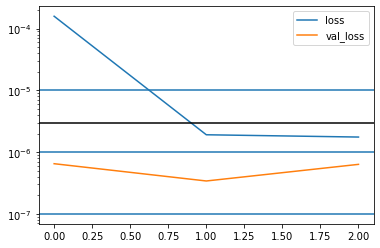

In [102]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.axhline(1e-5)
plt.axhline(1e-6)
plt.axhline(3e-6, c='k')
plt.axhline(1e-7)
plt.yscale("log")


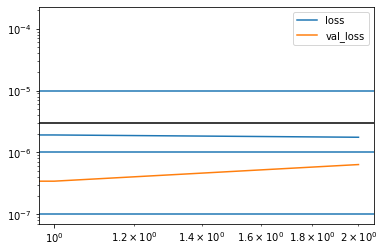

In [103]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.axhline(1e-5)
plt.axhline(1e-6)
plt.axhline(3e-6, c='k')
plt.axhline(1e-7)

In [104]:
try:
    plt.figure()
    plt.plot(history.history["lr"], label='lr')
    plt.legend()
    plt.yscale("log")
    # plt.xscale("log")
except:
    pass

<Figure size 432x288 with 0 Axes>

In [105]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 theta_input (InputLayer)       [(None, 4)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          256         ['time_input[0][0]']             
                                                                                                  
 dense_1 (Dense)                (None, 128)          640         ['theta_input[0][0]']            
                                                                                              

In [106]:
# test_input = build_input_single_q(times_train_scaled, *theta_val_scaled[-1])
test_input = build_input_single_q(times_train, *theta_val[-1])
# test_yhat = model.predict([test_input[:,0], test_input[:,1:]], verbose=0)
test_yhat = model([test_input[:,0], test_input[:,1:]])

In [107]:
test_input.shape

(4140, 5)

In [108]:
# %%timeit
# # model.predict([test_input[:,0], test_input[:,1:]], verbose=0)
# model([test_input[:,0], test_input[:,1:]])

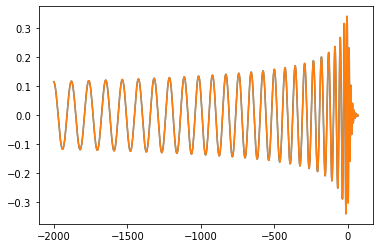

In [109]:
plt.plot(test_input[:,0], y_val_scaled[-1])
plt.plot(test_input[:,0], test_yhat[:,0], ls='-')
# plt.xlim(0.3, 0.5)
# plt.yscale('log')

(-500.0, 100.0)

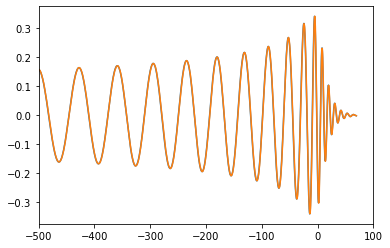

In [110]:
plt.plot(test_input[:,0], y_val_scaled[-1])
plt.plot(test_input[:,0], test_yhat[:,0], ls='-')
plt.xlim(-500, 100)
# plt.yscale('log')

In [111]:
X_val.shape

(414000, 5)

In [112]:
theta_val.shape

(100, 4)

In [113]:
times_val_scaled.shape

(4140, 1)

In [114]:
# yhat_val = model.predict([X_validation[:,0], X_validation[:,1:]], verbose=0)
yhat_val = model([X_val[:,0], X_val[:,1:]])

# this is: (num waveforms, num time samples)
shape_ = (theta_val.shape[0], times_val_scaled.shape[0])
print(shape_)

# yhat_val = yhat_val.reshape(shape_)
yhat_val = yhat_val.numpy().reshape(shape_)

(100, 4140)


In [115]:
mse_val = tf.keras.losses.mean_squared_error(y_val_scaled, yhat_val)

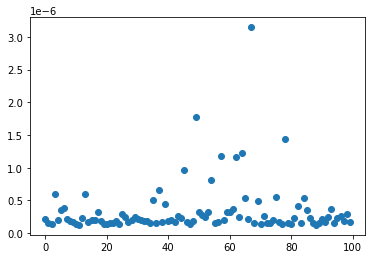

In [116]:
plt.plot(mse_val, 'o')

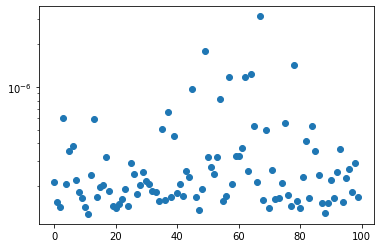

In [117]:
plt.plot(mse_val, 'o')
plt.yscale('log')

In [118]:
mse_val.shape

TensorShape([100])

In [119]:
print(mse_val.numpy().min())
print(mse_val.numpy().max())
print(mse_val.numpy().mean())
print(np.median(mse_val.numpy()))

1.2707842e-07
3.1459003e-06
3.4133012e-07
2.082319e-07


Text(0, 0.5, 'inclination')

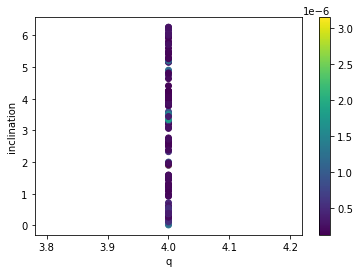

In [120]:
plt.scatter(theta_val[:,0], theta_val[:,1], c=mse_val)
plt.colorbar()
plt.xlabel('q')
plt.ylabel('inclination')

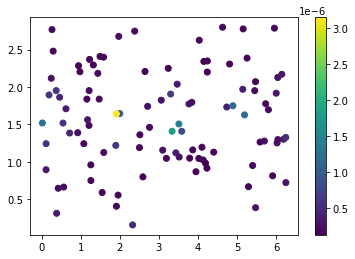

In [121]:
plt.scatter(theta_val[:,1], theta_val[:,2], c=mse_val)
plt.colorbar()
# plt.xlabel('q')
# plt.ylabel('spin1x')

Text(0, 0.5, 'spin1z')

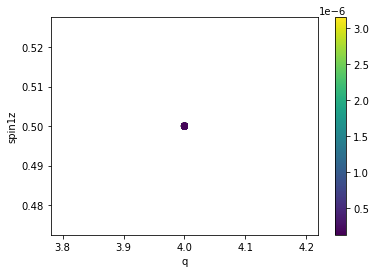

In [122]:
plt.scatter(theta_val[:,0], theta_val[:,3], c=mse_val)
plt.colorbar()
plt.xlabel('q')
plt.ylabel('spin1z')

Text(0, 0.5, 'spin1z')

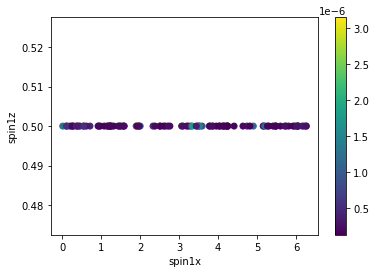

In [123]:
plt.scatter(theta_val[:,1], theta_val[:,3], c=mse_val)
plt.colorbar()
plt.xlabel('spin1x')
plt.ylabel('spin1z')

In [124]:
worst_idx = np.argmax(mse_val)
worst_idx


67

In [125]:
theta_val[worst_idx]

array([4.        , 1.91362055, 1.64163878, 0.5       ])

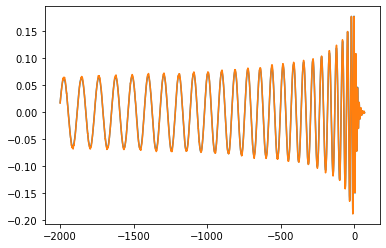

In [127]:
plt.figure()
plt.plot(times_val, y_val_scaled[worst_idx])
plt.plot(times_val, yhat_val[worst_idx])
# plt.xlim(-100, 120)

(-500.0, 120.0)

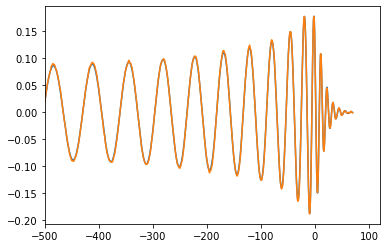

In [128]:
plt.figure()
plt.plot(times_val, y_val_scaled[worst_idx])
plt.plot(times_val, yhat_val[worst_idx])
plt.xlim(-500, 120)

In [129]:
plt.figure()
plt.plot(times_val, y_val_scaled[worst_idx]-yhat_val[worst_idx])
# plt.xlim(-100, 120)

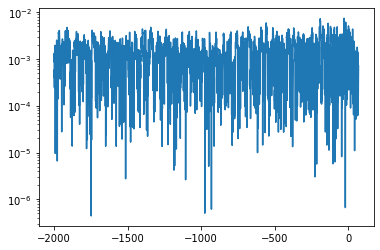

In [130]:
plt.figure()
plt.plot(times_val, np.abs(y_val_scaled[worst_idx]-yhat_val[worst_idx]))
# plt.xlim(-100, 120)
plt.yscale('log')